In [61]:
import warnings
warnings.filterwarnings('ignore')
# For ignoring warnings printed by R magic commands

In [62]:
# Load R magic
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [63]:
%%R
library(ggplot2)
library(ggthemes)
library(RColorBrewer)
library(stringr)
# library(tidyverse)
library(grid)
library(gridExtra)

plot_theme <- theme_hc(base_size = 15) +
              theme(plot.title = element_text(hjust = 0.5),
                    legend.position = "bottom", legend.title = element_blank())

# plot_theme <- theme_hc(base_size = 20) +
#               theme(plot.title = element_text(family = "Helvetica", hjust = 0.5), 
#                     legend.title = element_blank(), 
#                     legend.text = element_text(family = "Helvetica"), 
#                     legend.position = "bottom",
#                     axis.title = element_text(family = "Helvetica"),
#                     axis.text = element_text(family = "Courier"))

plot_color <- scale_colour_brewer(palette = "Set1")

get_legend<-function(myggplot){
  tmp <- ggplot_gtable(ggplot_build(myggplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

In [64]:
import pandas as pd

## 1. CDF Latencies for different workloads 

In [6]:
latencies = pd.read_csv('latencies.csv', sep=',')

In [7]:
latencies.head()

LambdaNIC    Docker  BareMetal       Type
0   0.000037  0.044910   0.001457  WebServer
1   0.000037  0.044937   0.001463  WebServer
2   0.000038  0.044945   0.001467  WebServer
3   0.000038  0.044949   0.001468  WebServer
4   0.000038  0.044958   0.001469  WebServer

In [8]:
latencies['Type'].unique()

array(['WebServer', 'Image Transform', 'Memcached Get', 'Memcached Set'], dtype=object)

In [9]:
def get_latencies(latencies, compute_type):
    if not 'Memcached' == compute_type:    
        _latencies = latencies[latencies['Type'] == compute_type][['LambdaNIC', 'Docker', 'BareMetal']]
    #     latencies.describe()
        _latencies = _latencies * float(1000)

        latencies_for_lambdanic = pd.DataFrame()
        latencies_for_lambdanic['Latency'] = _latencies['LambdaNIC']
        latencies_for_lambdanic['Type'] = 'Lambda-NIC'

        latencies_for_container = pd.DataFrame()
        latencies_for_container['Latency'] = _latencies['Docker']
        latencies_for_container['Type'] = 'Container'

        latencies_for_baremetal = pd.DataFrame()
        latencies_for_baremetal['Latency'] = _latencies['BareMetal']
        latencies_for_baremetal['Type'] = 'Bare Metal'

        _latencies = pd.concat([latencies_for_lambdanic,
                                latencies_for_container,
                                latencies_for_baremetal])

        return _latencies
    else:
        get_latencies = latencies[latencies['Type'] == 'Memcached Get'][['LambdaNIC', 'Docker', 'BareMetal']]
        get_latencies = get_latencies * float(1000)
        
        get_latencies_for_lambdanic = pd.DataFrame()
        get_latencies_for_lambdanic['Latency'] = get_latencies['LambdaNIC']
        get_latencies_for_lambdanic['Type'] = 'Lambda-NIC: Get'

        get_latencies_for_container = pd.DataFrame()
        get_latencies_for_container['Latency'] = get_latencies['Docker']
        get_latencies_for_container['Type'] = 'Container: Get'

        get_latencies_for_baremetal = pd.DataFrame()
        get_latencies_for_baremetal['Latency'] = get_latencies['BareMetal']
        get_latencies_for_baremetal['Type'] = 'Bare Metal: Get'

        set_latencies = latencies[latencies['Type'] == 'Memcached Set'][['LambdaNIC', 'Docker', 'BareMetal']]
        set_latencies = set_latencies * float(1000)
        
        set_latencies_for_lambdanic = pd.DataFrame()
        set_latencies_for_lambdanic['Latency'] = set_latencies['LambdaNIC']
        set_latencies_for_lambdanic['Type'] = 'Lambda-NIC: Set'

        set_latencies_for_container = pd.DataFrame()
        set_latencies_for_container['Latency'] = set_latencies['Docker']
        set_latencies_for_container['Type'] = 'Container: Set'

        set_latencies_for_baremetal = pd.DataFrame()
        set_latencies_for_baremetal['Latency'] = set_latencies['BareMetal']
        set_latencies_for_baremetal['Type'] = 'Bare Metal: Set'

        _latencies = pd.concat([get_latencies_for_lambdanic,
                                get_latencies_for_container,
                                get_latencies_for_baremetal,
                                set_latencies_for_lambdanic,
                                set_latencies_for_container,
                                set_latencies_for_baremetal])
        
        return _latencies

In [10]:
webserver_latencies = get_latencies(latencies, 'WebServer')

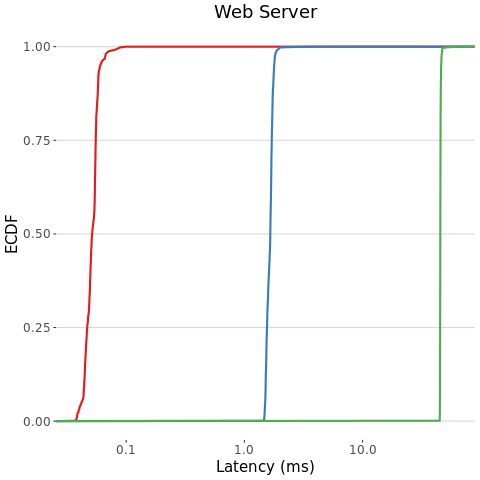

In [104]:
%%R -i webserver_latencies

webserver_latencies$Type <- factor(webserver_latencies$Type, 
                                   levels = c("Lambda-NIC", "Bare Metal", "Container"))

webserver_plot <- ggplot(webserver_latencies, aes(x=Latency, colour=Type)) + 
    geom_line(stat = "ecdf", size=1) +
#     coord_cartesian(xlim = c(0, 60)) +
    scale_x_continuous(trans = "log10") +
    labs(y = "ECDF", x = "Latency (ms)") +
    ggtitle("Web Server") +
    theme_hc(base_size = 15) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'none', legend.title = element_blank()) +
    plot_color

webserver_plot

In [12]:
imagetransform_latencies = get_latencies(latencies, 'Image Transform')

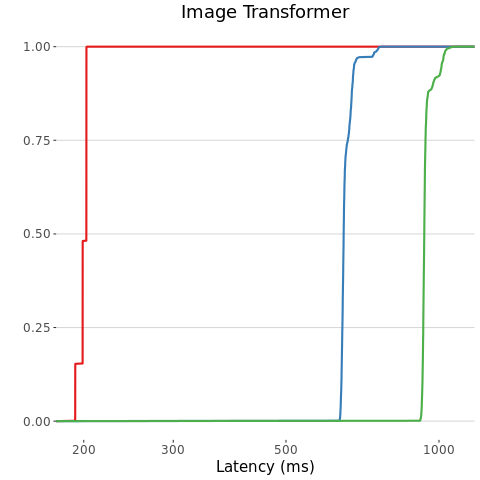

In [105]:
%%R -i imagetransform_latencies

imagetransform_latencies$Type <- factor(imagetransform_latencies$Type, 
                                        levels = c("Lambda-NIC", "Bare Metal", "Container"))

imagetransform_plot <- ggplot(imagetransform_latencies, aes(x=Latency, colour=Type)) + 
    geom_line(stat = "ecdf", size=1) +
#     coord_cartesian(xlim = c(0, 60)) +
    scale_x_continuous(trans = "log10", breaks=c(200, 300, 500, 1000)) +
    labs(y = "", x = "Latency (ms)") +
    ggtitle("Image Transformer") +
    theme_hc(base_size = 15) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'right', legend.title = element_blank()) +
    plot_color

common_legend <- get_legend(imagetransform_plot)

imagetransform_plot <- imagetransform_plot + theme(legend.position="none")

imagetransform_plot

In [14]:
memcachedset_latencies = get_latencies(latencies, 'Memcached Set')

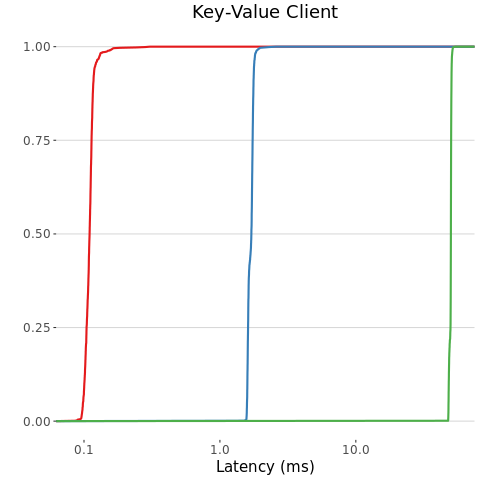

In [106]:
%%R -i memcachedset_latencies

memcachedset_latencies$Type <- factor(memcachedset_latencies$Type, 
                                      levels = c("Lambda-NIC", "Bare Metal", "Container"))

memcachedset_plot <- ggplot(memcachedset_latencies, aes(x=Latency, colour=Type)) + 
    geom_line(stat = "ecdf", size=1) +
#     coord_cartesian(xlim = c(0, 60)) +
    scale_x_continuous(trans = "log10") +
    labs(y = "", x = "Latency (ms)") +
    ggtitle("Key-Value Client") +
    theme_hc(base_size = 15) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'none', legend.title = element_blank()) +
    plot_color

memcachedset_plot

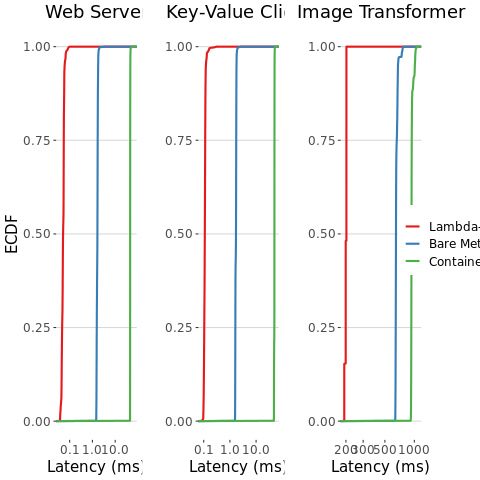

In [107]:
%%R
combined_plots <- grid.arrange(webserver_plot, memcachedset_plot, imagetransform_plot, common_legend,
                               ncol=4, widths=c(4, 4, 4, 1.5))
ggsave(combined_plots, height=2, width=13.5, file="output/cdf_of_workload_latencies.pdf")

## 2. Compiler optimizations

In [73]:
optimizations = pd.read_csv('optimizations.csv', sep=',')

In [74]:
optimizations

Unnamed: 0  Instructions  Unnamed: 2
0                   Unoptimized          8902         NaN
1  Coalesce Memcached Workloads          8624         NaN
2        Coalesce All Workloads          8447         NaN
3               Match Reduction          8132         NaN
4              Memory Hierarchy          8051         NaN

In [75]:
optimizations = optimizations[['Unnamed: 0', 'Instructions']]
optimizations.columns = ['Optimization', "Instructions"]
optimizations

Optimization  Instructions
0                   Unoptimized          8902
1  Coalesce Memcached Workloads          8624
2        Coalesce All Workloads          8447
3               Match Reduction          8132
4              Memory Hierarchy          8051

In [76]:
optimizations['Labels'] =  -(8902 - optimizations['Instructions']) / float(8902) * 100
optimizations['Labels'] = optimizations['Labels'].apply(lambda x: "{:.2f}".format(x)) + "%"
# optimizations['Labels'] = optimizations['Instructions'].astype(str) + "\n(" + optimizations['Labels'].astype(str) + "%)"
optimizations['Labels'][0] = optimizations['Instructions'].astype(str)[0]
optimizations

Optimization  Instructions  Labels
0                   Unoptimized          8902    8902
1  Coalesce Memcached Workloads          8624  -3.12%
2        Coalesce All Workloads          8447  -5.11%
3               Match Reduction          8132  -8.65%
4              Memory Hierarchy          8051  -9.56%

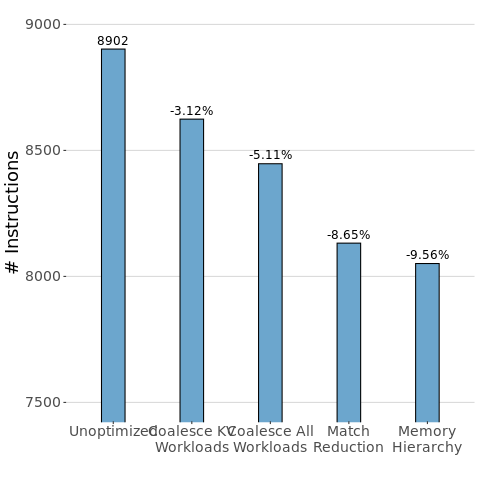

In [81]:
%%R -i optimizations

optimizations_plot <- ggplot(optimizations, aes(x=Optimization, y=Instructions)) +
    geom_bar(stat="identity", position=position_dodge(width=0.7), fill = "skyblue3", width = 0.3, colour="black") +
    geom_text(aes(label=Labels), vjust=-0.5,
              position = position_dodge(0.7), size=4.2) +
    labs(y = "# Instructions", x = "") +
    coord_cartesian(ylim = c(7500, 9000)) +
    scale_x_discrete(limits=c("Unoptimized", "Coalesce Memcached Workloads", "Coalesce All Workloads",
                              "Match Reduction", "Memory Hierarchy"),
                    labels=c("Unoptimized", "Coalesce KV\nWorkloads", "Coalesce All\nWorkloads",
                              "Match\nReduction", "Memory\nHierarchy")) +
    theme_hc(base_size = 18) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'none', legend.title = element_blank()) +
    plot_color
    
optimizations_plot

In [82]:
%%R
ggsave(optimizations_plot, height=3, width=7, file="output/compiler_optimizations.pdf")

## 3. Context switch latencies

In [65]:
context_switch_latencies  = pd.read_csv('context_switch_latencies.csv', sep=',')

In [66]:
context_switch_latencies.columns = ['LambdaNIC', 'BareMetal', 'BareMetalSingleCore']
context_switch_latencies = context_switch_latencies * float(1000)

In [67]:
context_switch_latencies.head()

LambdaNIC  BareMetal  BareMetalSingleCore
0     0.0413   2.025774             7.939365
1     0.0419   4.126996             9.118818
2     0.0421   4.918988            10.485806
3     0.0422   5.788246            11.395761
4     0.0426   6.694970            19.447385

In [68]:
lambdanic_context_switch_latencies = pd.DataFrame()
lambdanic_context_switch_latencies['Latency'] = context_switch_latencies['LambdaNIC']
lambdanic_context_switch_latencies['Type'] = 'Lambda-NIC'

baremetal_context_switch_latencies = pd.DataFrame()
baremetal_context_switch_latencies['Latency'] = context_switch_latencies['BareMetal']
baremetal_context_switch_latencies['Type'] = 'Bare Metal'

baremetalsc_context_switch_latencies = pd.DataFrame()
baremetalsc_context_switch_latencies['Latency'] = context_switch_latencies['BareMetalSingleCore']
baremetalsc_context_switch_latencies['Type'] = 'Bare Metal (Single Core)'

proc_context_switch_latencies = pd.concat([lambdanic_context_switch_latencies,
                                           baremetal_context_switch_latencies,
                                           baremetalsc_context_switch_latencies])

In [69]:
proc_context_switch_latencies.head()

Latency        Type
0   0.0413  Lambda-NIC
1   0.0419  Lambda-NIC
2   0.0421  Lambda-NIC
3   0.0422  Lambda-NIC
4   0.0426  Lambda-NIC

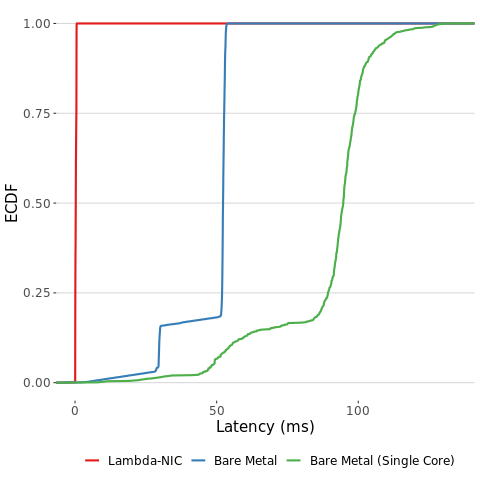

In [70]:
%%R -i proc_context_switch_latencies

proc_context_switch_latencies$Type <- factor(proc_context_switch_latencies$Type, 
                                             levels = c("Lambda-NIC", "Bare Metal", "Bare Metal (Single Core)"))

context_switch_latencies_plot <- ggplot(proc_context_switch_latencies, aes(x=Latency, colour=Type)) + 
    geom_line(stat = "ecdf", size=1) +
#     scale_x_continuous(trans = "log10") +
    labs(y = "ECDF", x = "Latency (ms)") +
    theme_hc(base_size = 15) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'bottom', legend.title = element_blank()) +
    plot_color

context_switch_latencies_plot

In [72]:
%%R
ggsave(context_switch_latencies_plot, height=3, width=6, file="output/cdf_of_context_switch_latencies.pdf")

## 4. Workload throughput

In [53]:
workload_completion_times  = pd.read_csv('throughput.csv', sep=',')

In [54]:
workload_completion_times.columns = ['Lambda-NIC', 'Container', 'Bare Metal', 'Threads', 'Workload']
workload_completion_times = workload_completion_times[workload_completion_times['Workload'] != 'Memcached GET']

In [55]:
workload_completion_times.head(10)

Lambda-NIC    Container   Bare Metal  Threads         Workload
0     0.618531   455.183745    16.366419        1       Web Server
1     0.175127    34.638779     9.619521       56       Web Server
2  1923.806019  9395.262846  5932.755653        1  Image Transform
3    48.682618   720.206395   240.818860       56  Image Transform
6     1.207767   515.491825    17.026772        1    Memcached SET
7     0.395159    39.003949    10.038129       56    Memcached SET

In [60]:
workload_throughput = workload_completion_times.copy()

In [61]:
workload_throughput['Lambda-NIC'] = 10000.0 / workload_completion_times['Lambda-NIC']
workload_throughput['Container'] = 10000.0 / workload_completion_times['Container']
workload_throughput['Bare Metal'] = 10000.0 / workload_completion_times['Bare Metal']

In [62]:
workload_throughput.head(10)

Lambda-NIC   Container   Bare Metal  Threads         Workload
0  16167.338420   21.969150   611.007224        1       Web Server
1  57101.417828  288.693775  1039.552801       56       Web Server
2      5.198029    1.064366     1.685557        1  Image Transform
3    205.412126   13.884909    41.524987       56  Image Transform
6   8279.739957   19.398950   587.310391        1    Memcached SET
7  25306.243506  256.384297   996.201583       56    Memcached SET

In [64]:
lambdanic_workload_throughput = pd.DataFrame()
lambdanic_workload_throughput['Throughput'] = workload_throughput['Lambda-NIC']
lambdanic_workload_throughput['Threads'] = workload_throughput['Threads']
lambdanic_workload_throughput['Workload'] = workload_throughput['Workload']
lambdanic_workload_throughput['Type'] = 'Lambda-NIC'

container_workload_throughput = pd.DataFrame()
container_workload_throughput['Throughput'] = workload_throughput['Container']
container_workload_throughput['Threads'] = workload_throughput['Threads']
container_workload_throughput['Workload'] = workload_throughput['Workload']
container_workload_throughput['Type'] = 'Container'

baremetal_workload_throughput = pd.DataFrame()
baremetal_workload_throughput['Throughput'] = workload_throughput['Bare Metal']
baremetal_workload_throughput['Threads'] = workload_throughput['Threads']
baremetal_workload_throughput['Workload'] = workload_throughput['Workload']
baremetal_workload_throughput['Type'] = 'Bare Metal'

proc_workload_throughput = pd.concat([lambdanic_workload_throughput,
                                      container_workload_throughput,
                                      baremetal_workload_throughput])

proc_workload_throughput['Threads'] = proc_workload_throughput['Threads'].apply(lambda x: "1 Thread" if x == 1 else "56 Threads")
# proc_workload_throughput['Threads'] = proc_workload_throughput['Threads'].astype(str)
proc_workload_throughput['Labels'] = proc_workload_throughput['Throughput'].apply(lambda x: "{:.1f}".format(x))

In [66]:
proc_workload_throughput.head(10)

Throughput     Threads         Workload        Type   Labels
0  16167.338420    1 Thread       Web Server  Lambda-NIC  16167.3
1  57101.417828  56 Threads       Web Server  Lambda-NIC  57101.4
2      5.198029    1 Thread  Image Transform  Lambda-NIC      5.2
3    205.412126  56 Threads  Image Transform  Lambda-NIC    205.4
6   8279.739957    1 Thread    Memcached SET  Lambda-NIC   8279.7
7  25306.243506  56 Threads    Memcached SET  Lambda-NIC  25306.2
0     21.969150    1 Thread       Web Server   Container     22.0
1    288.693775  56 Threads       Web Server   Container    288.7
2      1.064366    1 Thread  Image Transform   Container      1.1
3     13.884909  56 Threads  Image Transform   Container     13.9

In [68]:
 proc_workload_throughput['Workload'] = proc_workload_throughput['Workload'].replace(regex=['Memcached SET'], value='KV Client')

In [69]:
proc_workload_throughput.head(10)

Throughput     Threads         Workload        Type   Labels
0  16167.338420    1 Thread       Web Server  Lambda-NIC  16167.3
1  57101.417828  56 Threads       Web Server  Lambda-NIC  57101.4
2      5.198029    1 Thread  Image Transform  Lambda-NIC      5.2
3    205.412126  56 Threads  Image Transform  Lambda-NIC    205.4
6   8279.739957    1 Thread        KV Client  Lambda-NIC   8279.7
7  25306.243506  56 Threads        KV Client  Lambda-NIC  25306.2
0     21.969150    1 Thread       Web Server   Container     22.0
1    288.693775  56 Threads       Web Server   Container    288.7
2      1.064366    1 Thread  Image Transform   Container      1.1
3     13.884909  56 Threads  Image Transform   Container     13.9

In [70]:
webserver_workload_throughput = proc_workload_throughput[proc_workload_throughput['Workload'] == 'Web Server']
webserver_workload_throughput = webserver_workload_throughput[['Throughput', 'Threads', 'Type', 'Labels']]
webserver_workload_throughput

Throughput     Threads        Type   Labels
0  16167.338420    1 Thread  Lambda-NIC  16167.3
1  57101.417828  56 Threads  Lambda-NIC  57101.4
0     21.969150    1 Thread   Container     22.0
1    288.693775  56 Threads   Container    288.7
0    611.007224    1 Thread  Bare Metal    611.0
1   1039.552801  56 Threads  Bare Metal   1039.6

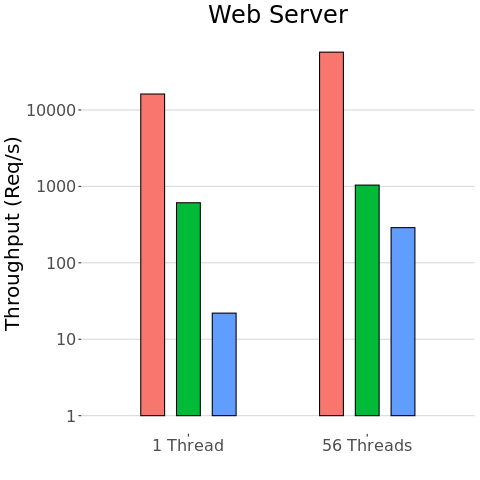

In [101]:
%%R -i webserver_workload_throughput

webserver_workload_throughput$Type <- factor(webserver_workload_throughput$Type, 
                                             levels = c("Lambda-NIC", "Bare Metal", "Container"))

webserver_workload_throughput_plot <- ggplot(webserver_workload_throughput, 
                                             aes(x=Threads, y=Throughput, fill=Type)) + 
    geom_bar(stat="identity", position=position_dodge(width=0.6), width=0.4, color='black') +
#     geom_text(aes(label=Labels), vjust=-0.5, 
#               position = position_dodge(0.8), size=4.5) +
    labs(y = "Throughput (Req/s)", x = "") +
    scale_y_continuous(trans = "log10") +
#     scale_x_discrete(limits=c("Unoptimized", "Coalesce Memcached Workloads", "Coalesce All Workloads",
#                               "Match Reduction", "Memory Hierarchy"),
#                     labels=c("Unoptimized", "Coalesce\nMemcached\nWorkloads", "Coalesce All\nWorkloads",
#                               "Match\nReduction", "Memory\nHierarchy")) +
    ggtitle("Web Server") +
    theme_hc(base_size = 20) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'none', legend.title = element_blank()) +
    plot_color
    
webserver_workload_throughput_plot

In [77]:
kvclient_workload_throughput = proc_workload_throughput[proc_workload_throughput['Workload'] == 'KV Client']
kvclient_workload_throughput = kvclient_workload_throughput[['Throughput', 'Threads', 'Type', 'Labels']]
kvclient_workload_throughput

Throughput     Threads        Type   Labels
6   8279.739957    1 Thread  Lambda-NIC   8279.7
7  25306.243506  56 Threads  Lambda-NIC  25306.2
6     19.398950    1 Thread   Container     19.4
7    256.384297  56 Threads   Container    256.4
6    587.310391    1 Thread  Bare Metal    587.3
7    996.201583  56 Threads  Bare Metal    996.2

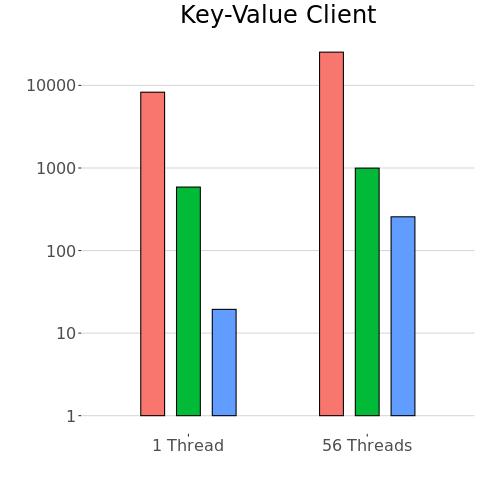

In [100]:
%%R -i kvclient_workload_throughput

kvclient_workload_throughput$Type <- factor(kvclient_workload_throughput$Type, 
                                             levels = c("Lambda-NIC", "Bare Metal", "Container"))

kvclient_workload_throughput_plot <- ggplot(kvclient_workload_throughput, 
                                             aes(x=Threads, y=Throughput, fill=Type)) + 
    geom_bar(stat="identity", position=position_dodge(width=0.6), width=0.4, color='black') +
#     geom_text(aes(label=Labels), vjust=-0.5, 
#               position = position_dodge(0.8), size=4.5) +
    labs(y = "", x = "") +
    scale_y_continuous(trans = "log10") +
#     scale_x_discrete(limits=c("Unoptimized", "Coalesce Memcached Workloads", "Coalesce All Workloads",
#                               "Match Reduction", "Memory Hierarchy"),
#                     labels=c("Unoptimized", "Coalesce\nMemcached\nWorkloads", "Coalesce All\nWorkloads",
#                               "Match\nReduction", "Memory\nHierarchy")) +
    ggtitle("Key-Value Client") +
    theme_hc(base_size = 20) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'right', legend.title = element_blank()) +
    plot_color

common_legend <- get_legend(kvclient_workload_throughput_plot)

kvclient_workload_throughput_plot <- kvclient_workload_throughput_plot + theme(legend.position="none")
    
kvclient_workload_throughput_plot

In [79]:
imagetransform_workload_throughput = proc_workload_throughput[proc_workload_throughput['Workload'] == 'Image Transform']
imagetransform_workload_throughput = imagetransform_workload_throughput[['Throughput', 'Threads', 'Type', 'Labels']]
imagetransform_workload_throughput

Throughput     Threads        Type Labels
2    5.198029    1 Thread  Lambda-NIC    5.2
3  205.412126  56 Threads  Lambda-NIC  205.4
2    1.064366    1 Thread   Container    1.1
3   13.884909  56 Threads   Container   13.9
2    1.685557    1 Thread  Bare Metal    1.7
3   41.524987  56 Threads  Bare Metal   41.5

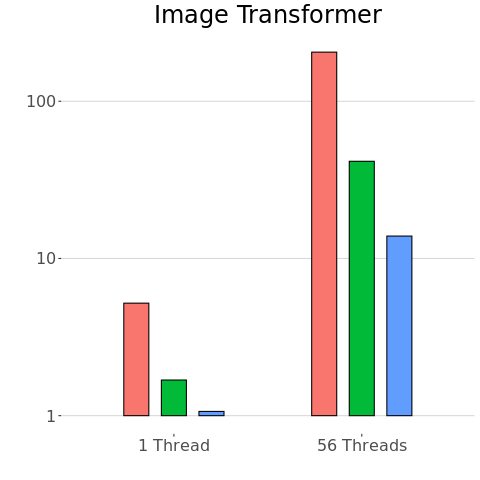

In [99]:
%%R -i imagetransform_workload_throughput

imagetransform_workload_throughput$Type <- factor(imagetransform_workload_throughput$Type, 
                                             levels = c("Lambda-NIC", "Bare Metal", "Container"))

imagetransform_workload_throughput_plot <- ggplot(imagetransform_workload_throughput, 
                                             aes(x=Threads, y=Throughput, fill=Type)) + 
    geom_bar(stat="identity", position=position_dodge(width=0.6), width=0.4, color='black') +
#     geom_text(aes(label=Labels), vjust=-0.5, 
#               position = position_dodge(0.8), size=4.5) +
    labs(y = "", x = "") +
    scale_y_continuous(trans = "log10") +
#     scale_x_discrete(limits=c("Unoptimized", "Coalesce Memcached Workloads", "Coalesce All Workloads",
#                               "Match Reduction", "Memory Hierarchy"),
#                     labels=c("Unoptimized", "Coalesce\nMemcached\nWorkloads", "Coalesce All\nWorkloads",
#                               "Match\nReduction", "Memory\nHierarchy")) +
    ggtitle("Image Transformer") +
    theme_hc(base_size = 20) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'none', legend.title = element_blank()) +
    plot_color
    
imagetransform_workload_throughput_plot

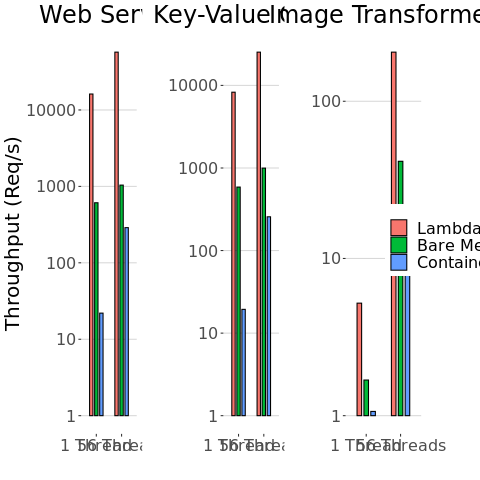

In [102]:
%%R
combined_plots <- grid.arrange(webserver_workload_throughput_plot, kvclient_workload_throughput_plot, 
                               imagetransform_workload_throughput_plot, common_legend,
                               ncol=4, widths=c(4, 4, 4, 1.5))
ggsave(combined_plots, height=3, width=18.5, file="output/workload_throughput.pdf")

## 4. Workload completion times

In [38]:
workload_completion_times  = pd.read_csv('throughput.csv', sep=',')

In [41]:
workload_completion_times.columns = ['Lambda-NIC', 'Container', 'Bare Metal', 'Threads', 'Workload']
workload_completion_times = workload_completion_times[workload_completion_times['Workload'] != 'Memcached GET']

In [42]:
workload_completion_times.head(10)

Lambda-NIC    Container   Bare Metal  Threads         Workload
0     0.618531   455.183745    16.366419        1       Web Server
1     0.175127    34.638779     9.619521       56       Web Server
2  1923.806019  9395.262846  5932.755653        1  Image Transform
3    48.682618   720.206395   240.818860       56  Image Transform
6     1.207767   515.491825    17.026772        1    Memcached SET
7     0.395159    39.003949    10.038129       56    Memcached SET

In [43]:
lambdanic_workload_completion_times = pd.DataFrame()
lambdanic_workload_completion_times['Time'] = workload_completion_times['Lambda-NIC']
lambdanic_workload_completion_times['Threads'] = workload_completion_times['Threads']
lambdanic_workload_completion_times['Workload'] = workload_completion_times['Workload']
lambdanic_workload_completion_times['Type'] = 'Lambda-NIC'

container_workload_completion_times = pd.DataFrame()
container_workload_completion_times['Time'] = workload_completion_times['Container']
container_workload_completion_times['Threads'] = workload_completion_times['Threads']
container_workload_completion_times['Workload'] = workload_completion_times['Workload']
container_workload_completion_times['Type'] = 'Container'

baremetal_workload_completion_times = pd.DataFrame()
baremetal_workload_completion_times['Time'] = workload_completion_times['Bare Metal']
baremetal_workload_completion_times['Threads'] = workload_completion_times['Threads']
baremetal_workload_completion_times['Workload'] = workload_completion_times['Workload']
baremetal_workload_completion_times['Type'] = 'Bare Metal'

proc_workload_completion_times = pd.concat([lambdanic_workload_completion_times,
                                            container_workload_completion_times,
                                            baremetal_workload_completion_times])

proc_workload_completion_times['Threads'] = proc_workload_completion_times['Threads'].apply(lambda x: "1 Thread" if x == 1 else "56 Threads")
# proc_workload_completion_times['Threads'] = proc_workload_completion_times['Threads'].astype(str)
proc_workload_completion_times['Labels'] = proc_workload_completion_times['Time'].apply(lambda x: "{:.1f}".format(x))

In [44]:
proc_workload_completion_times.head()

Time     Threads         Workload        Type  Labels
0     0.618531    1 Thread       Web Server  Lambda-NIC     0.6
1     0.175127  56 Threads       Web Server  Lambda-NIC     0.2
2  1923.806019    1 Thread  Image Transform  Lambda-NIC  1923.8
3    48.682618  56 Threads  Image Transform  Lambda-NIC    48.7
6     1.207767    1 Thread    Memcached SET  Lambda-NIC     1.2

In [46]:
webserver_workload_completion_times = proc_workload_completion_times[proc_workload_completion_times['Workload'] == 'Web Server']
webserver_workload_completion_times = webserver_workload_completion_times[['Time', 'Threads', 'Type', 'Labels']]
webserver_workload_completion_times

Time     Threads        Type Labels
0    0.618531    1 Thread  Lambda-NIC    0.6
1    0.175127  56 Threads  Lambda-NIC    0.2
0  455.183745    1 Thread   Container  455.2
1   34.638779  56 Threads   Container   34.6
0   16.366419    1 Thread  Bare Metal   16.4
1    9.619521  56 Threads  Bare Metal    9.6

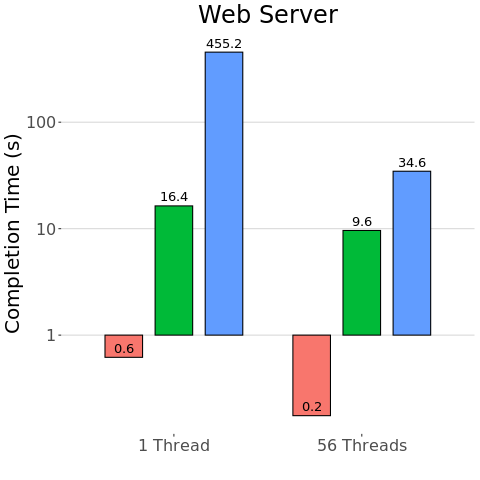

In [47]:
%%R -i webserver_workload_completion_times

webserver_workload_completion_times$Type <- factor(webserver_workload_completion_times$Type, 
                                                   levels = c("Lambda-NIC", "Bare Metal", "Container"))

webserver_workload_completion_times_plot <- ggplot(webserver_workload_completion_times, 
                                                   aes(x=Threads, y=Time, fill=Type)) + 
    geom_bar(stat="identity", position=position_dodge(width=0.8), width=0.6, color='black') +
    geom_text(aes(label=Labels), vjust=-0.5, 
              position = position_dodge(0.8), size=4.5) +
    labs(y = "Completion Time (s)", x = "") +
    scale_y_continuous(trans = "log10") +
#     scale_x_discrete(limits=c("Unoptimized", "Coalesce Memcached Workloads", "Coalesce All Workloads",
#                               "Match Reduction", "Memory Hierarchy"),
#                     labels=c("Unoptimized", "Coalesce\nMemcached\nWorkloads", "Coalesce All\nWorkloads",
#                               "Match\nReduction", "Memory\nHierarchy")) +
    ggtitle("Web Server") +
    theme_hc(base_size = 20) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'none', legend.title = element_blank()) +
    plot_color
    
webserver_workload_completion_times_plot

In [48]:
memcached_workload_completion_times = proc_workload_completion_times[proc_workload_completion_times['Workload'] == 'Memcached SET']
memcached_workload_completion_times = memcached_workload_completion_times[['Time', 'Threads', 'Type', 'Labels']]
memcached_workload_completion_times

Time     Threads        Type Labels
6    1.207767    1 Thread  Lambda-NIC    1.2
7    0.395159  56 Threads  Lambda-NIC    0.4
6  515.491825    1 Thread   Container  515.5
7   39.003949  56 Threads   Container   39.0
6   17.026772    1 Thread  Bare Metal   17.0
7   10.038129  56 Threads  Bare Metal   10.0

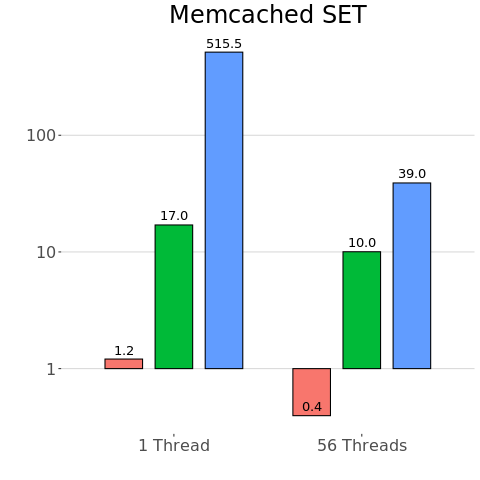

In [49]:
%%R -i memcached_workload_completion_times

memcached_workload_completion_times$Type <- factor(memcached_workload_completion_times$Type, 
                                                   levels = c("Lambda-NIC", "Bare Metal", "Container"))

memcached_workload_completion_times_plot <- ggplot(memcached_workload_completion_times, 
                                                   aes(x=Threads, y=Time, fill=Type)) + 
    geom_bar(stat="identity", position=position_dodge(width=0.8), width=0.6, color='black') +
    geom_text(aes(label=Labels), vjust=-0.5, 
              position = position_dodge(0.8), size=4.5) +
    labs(y = "", x = "") +
    scale_y_continuous(trans = "log10") +
#     scale_x_discrete(limits=c("Unoptimized", "Coalesce Memcached Workloads", "Coalesce All Workloads",
#                               "Match Reduction", "Memory Hierarchy"),
#                     labels=c("Unoptimized", "Coalesce\nMemcached\nWorkloads", "Coalesce All\nWorkloads",
#                               "Match\nReduction", "Memory\nHierarchy")) +
    ggtitle("Memcached SET") +
    theme_hc(base_size = 20) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'right', legend.title = element_blank()) +
    plot_color

common_legend <- get_legend(memcached_workload_completion_times_plot)

memcached_workload_completion_times_plot <- memcached_workload_completion_times_plot + theme(legend.position="none")
    
memcached_workload_completion_times_plot

In [50]:
imagetransform_workload_completion_times = proc_workload_completion_times[proc_workload_completion_times['Workload'] == 'Image Transform']
imagetransform_workload_completion_times = imagetransform_workload_completion_times[['Time', 'Threads', 'Type', 'Labels']]
imagetransform_workload_completion_times

Time     Threads        Type  Labels
2  1923.806019    1 Thread  Lambda-NIC  1923.8
3    48.682618  56 Threads  Lambda-NIC    48.7
2  9395.262846    1 Thread   Container  9395.3
3   720.206395  56 Threads   Container   720.2
2  5932.755653    1 Thread  Bare Metal  5932.8
3   240.818860  56 Threads  Bare Metal   240.8

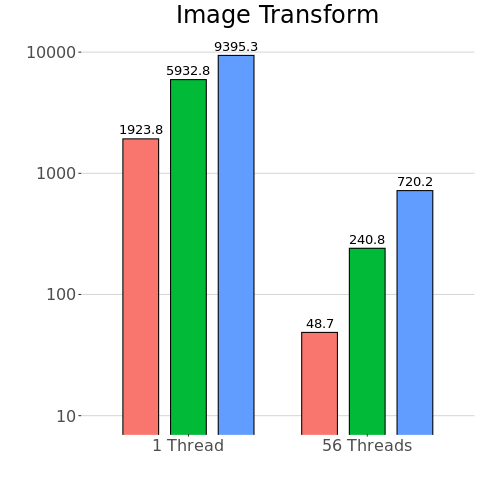

In [51]:
%%R -i imagetransform_workload_completion_times

imagetransform_workload_completion_times$Type <- factor(imagetransform_workload_completion_times$Type, 
                                                        levels = c("Lambda-NIC", "Bare Metal", "Container"))

imagetransform_workload_completion_times_plot <- ggplot(imagetransform_workload_completion_times, 
                                                   aes(x=Threads, y=Time, fill=Type)) + 
    geom_bar(stat="identity", position=position_dodge(width=0.8), width=0.6, color='black') +
    geom_text(aes(label=Labels), vjust=-0.5, 
              position = position_dodge(0.8), size=4.5) +
    labs(y = "", x = "") +
    scale_y_continuous(trans = "log10") +
    coord_cartesian(ylim = c(10, 10000)) +
#     scale_x_discrete(limits=c("Unoptimized", "Coalesce Memcached Workloads", "Coalesce All Workloads",
#                               "Match Reduction", "Memory Hierarchy"),
#                     labels=c("Unoptimized", "Coalesce\nMemcached\nWorkloads", "Coalesce All\nWorkloads",
#                               "Match\nReduction", "Memory\nHierarchy")) +
    ggtitle("Image Transform") +
    theme_hc(base_size = 20) +
    theme(plot.title = element_text(hjust = 0.5),
          legend.position = 'none', legend.title = element_blank()) +
    plot_color
    
imagetransform_workload_completion_times_plot

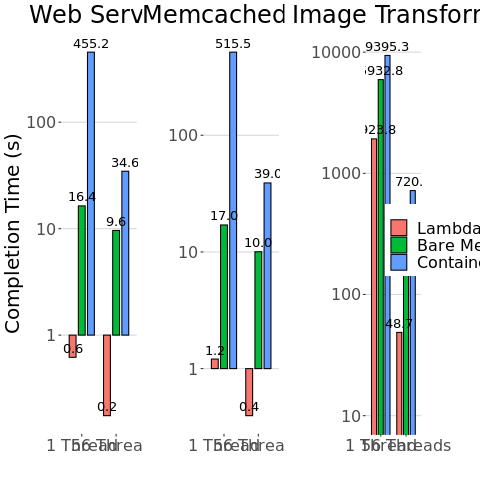

In [52]:
%%R
combined_plots <- grid.arrange(webserver_workload_completion_times_plot, memcached_workload_completion_times_plot, 
                               imagetransform_workload_completion_times_plot, common_legend,
                               ncol=4, widths=c(4, 4, 4, 1.5))
ggsave(combined_plots, height=5.5, width=18.5, file="output/workload_completion_times.pdf")